In [ ]:
#@title Getting started { display-mode: "form" }
#@markdown Set up the environment, and download the raw data from ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) used throughout the praktikum:
#@markdown - Remove Colab `/content/sample_data/` directory to avoid confusion
!rm -rf sample_data

#@markdown - Upgrade scikit-learn, as the default Colab version does not have `DecisionBoundaryDisplay`
!pip install -U scikit-learn

#@markdown - Download ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) supplementary materials & store them under `/content/` as `Krug2020_S1.xlsx` etc
!wget -nv -O Krug2020_S1.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc1.xlsx
!wget -nv -O Krug2020_S2.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc2.xlsx
!wget -nv -O Krug2020_S3.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc3.xlsx

#@markdown - Import modules from numpy, pandas, seaborn, sklearn
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing

#@markdown - Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4 # https://xkcd.com/221

def plot_question_mark(ax):
  ax.text(x=.5, y=.5, s='?', color='red', fontsize=64,
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-04 08:57:56 URL:https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc1.xlsx [2491045/2491045] -> "Krug2020_S1.xlsx" [1]
2023-04-04 08:57:58 URL:https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc2.xlsx [89152124/89152124] -> "Krug2020_S2.xlsx" [1]
2023-04-04 08:57:58 URL:https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc3.xlsx [4573671/4573671] -> "Krug2020_S3.xlsx" [1]


# 1 Data wrangling

Load metadata

In [ ]:
df_metadata = pd.read_excel('Krug2020_S1.xlsx', sheet_name='A) Metadata')
df_metadata.head(3).transpose()

,0,1,2
Sample.ID,CPT000814,CPT001846,X01BR001
Sample.IDs,CPT000814,CPT001846,X01BR001
TMT.Plex,13,12,2
TMT.Channel,127C,128C,129N
Tumor.Stage,Stage IIA,Stage III,Stage IIB
Ischemia.Time.in.Minutes,NaN,NaN,0.0
PAM50,Basal,Basal,Basal
NMF.Cluster,Basal-I,Basal-I,Basal-I
NMF.Cluster.Membership.Score,1.0,0.672,0.782
Age.in.Month,unknown,unknown,660


Load mRNA values

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
df_mRNA = pd.read_excel('Krug2020_S2.xlsx', sheet_name='E) mRNA', index_col=0)
df_mRNA.head(3)

,description,CPT000814,CPT001846,X01BR001,X01BR008,X01BR009,X01BR010,X01BR015,X01BR017,X01BR018,...,X20BR002,X20BR005,X20BR006,X20BR007,X20BR008,X21BR001,X21BR002,X21BR010,X22BR005,X22BR006
id,,,,,,,,,,,,,,,,,,,,,
A1BG,alpha-1-B glycoprotein,1.9265,3.6578,0.9896,0.5535,2.8359,1.5804,1.9006,-0.8184,-0.2645,...,4.7120,NaN,NaN,NaN,NaN,2.1736,NaN,-0.3261,-1.2102,0.7403
A1BG-AS1,A1BG antisense RNA 1,2.4267,2.6524,2.6363,2.2119,3.3449,2.1647,2.5487,-0.3528,1.3557,...,1.9708,1.7106,0.6634,0.3475,1.3309,2.1405,NaN,1.0329,0.6457,1.6475
A1CF,APOBEC1 complementation factor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Look at TNBC values

In [ ]:
df_metadata['TNBC.Updated.Clinical.Status'].value_counts()

negative    91
positive    28
unknown      3
Name: TNBC.Updated.Clinical.Status, dtype: int64

Drop TNBC missing values; merge with expression values

In [ ]:
df_ = df_metadata[['Sample.ID', 'TNBC.Updated.Clinical.Status']].query('`TNBC.Updated.Clinical.Status` != "unknown"').merge(
  df_mRNA.drop(['description'], axis=1).transpose(),
  left_on='Sample.ID', right_index=True).set_index('Sample.ID')
df_.head(10)

,TNBC.Updated.Clinical.Status,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Sample.ID,,,,,,,,,,,,,,,,,,,,,
CPT000814,positive,1.9265,2.4267,NaN,5.3718,3.6437,-4.5301,-5.2608,0.6260,NaN,...,3.2268,5.1482,-0.0202,0.9270,5.1699,3.1333,0.9835,5.9499,2.8499,3.6497
CPT001846,positive,3.6578,2.6524,NaN,5.3253,-5.1069,-0.7692,5.6915,3.2060,NaN,...,3.2532,3.9191,-1.4924,-0.3262,3.2163,NaN,2.0909,7.0671,2.0780,3.2274
X01BR001,positive,0.9896,2.6363,NaN,5.4734,-1.5052,-2.0918,NaN,1.8816,NaN,...,1.9491,2.2365,0.1694,1.3074,2.8806,0.5653,1.5682,4.3852,2.1573,2.1127
X01BR009,positive,2.8359,3.3449,NaN,6.9307,2.6488,-3.1664,NaN,1.9784,-5.7975,...,2.7678,3.5378,-0.5147,0.2798,3.0986,-3.2737,1.3036,5.0219,3.6868,2.8524
X01BR010,positive,1.5804,2.1647,NaN,5.5849,-1.9207,-5.2335,-2.9630,0.7968,NaN,...,2.0857,3.7302,-0.3005,1.2738,3.4205,NaN,1.4754,7.0262,3.1389,2.7884
X01BR015,negative,1.9006,2.5487,NaN,6.5595,-3.9870,-2.7246,NaN,1.3805,NaN,...,2.2723,4.5702,0.6005,1.8828,1.9207,-1.0412,2.3020,4.7497,2.4845,4.1535
X01BR017,negative,-0.8184,-0.3528,NaN,6.5173,1.5757,NaN,NaN,1.1546,NaN,...,3.0989,4.8602,0.5538,1.8231,3.7417,2.3889,1.7353,4.6468,2.3066,3.3597
X01BR018,negative,-0.2645,1.3557,NaN,6.4225,2.6926,-3.0321,NaN,2.6610,NaN,...,2.8151,5.1622,0.5782,1.5874,3.3365,2.1095,2.2652,4.3992,2.3492,4.4671
X01BR020,positive,NaN,NaN,-8.1821,6.2846,-2.8500,NaN,NaN,0.1757,NaN,...,3.3276,5.2051,1.1959,1.4378,2.6126,1.9445,1.5354,4.6487,2.5095,2.9229


# 2 Exploring the data


The code below shows EGFR expression levels for TNBC positive/negative groups. Can you add subplots showing the same information for ERBB2 and PGR expression levels? Can you rank the usefulness of the features for TNBC classification by eyeballing?

NameError: ignored

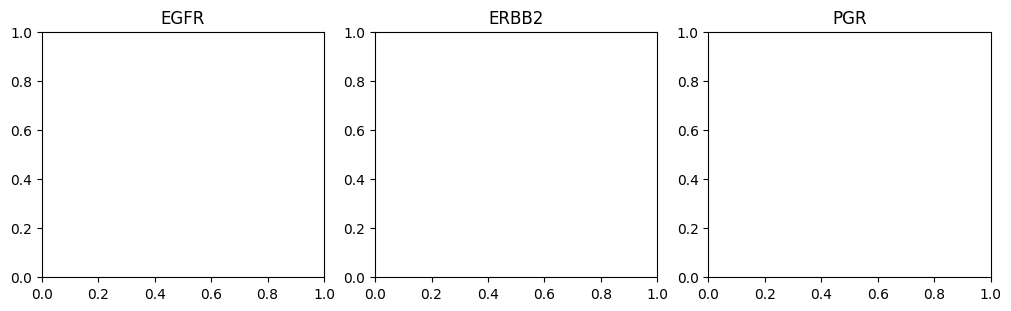

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), constrained_layout=True)
ax1.set_title('EGFR'); ax2.set_title('ERBB2'); ax3.set_title('PGR')
sns.violinplot(data=df_, y='EGFR', x='TNBC.Updated.Clinical.Status', ax=ax1);
plot_question_mark(ax2)
plot_question_mark(ax3)

# Solution:
#sns.violinplot(data=df_, y='ERBB2', x='TNBC.Updated.Clinical.Status', ax=ax2);
#sns.violinplot(data=df_, y='PGR', x='TNBC.Updated.Clinical.Status', ax=ax3);

The code below plots an ROC curve for EGFR expression levels. Can you add additional ROC plots for ERBB2 and PGR? Some of the curves/AUC values will be small (<0.5). How would you interpret this? Can you think of a way to adjust the plots to make them more comparable?



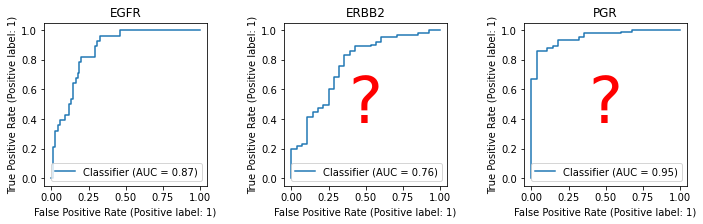

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), constrained_layout=True)
ax1.set_title('EGFR'); ax2.set_title('ERBB2'); ax3.set_title('PGR')
for ax_ in (ax1, ax2, ax3): ax_.set_aspect('equal')
sklearn.metrics.RocCurveDisplay.from_predictions(y_true=df_['TNBC.Updated.Clinical.Status'] == 'positive', y_pred=df_['EGFR'], ax=ax1);
plot_question_mark(ax2)
plot_question_mark(ax3)

# Solution - need to switch labels from positive to negative:
sklearn.metrics.RocCurveDisplay.from_predictions(y_true=df_['TNBC.Updated.Clinical.Status'] == 'negative', y_pred=df_['ERBB2'], ax=ax2);
sklearn.metrics.RocCurveDisplay.from_predictions(y_true=df_['TNBC.Updated.Clinical.Status'] == 'negative', y_pred=df_['PGR'], ax=ax3);

# 3 Visualising classifier output
Left shows a scatter plot of EGFR, ERBB2 colored by class labels. Center plot shows a decision boundary of a linear classifier trained on all the data. Add a plot to the right, showing the decision boundary for a more complicated model, such as `KNeighborsClassifier()` or `DecisionTreeClassifier()`?

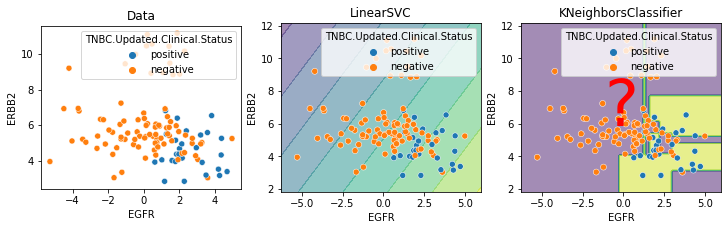

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), constrained_layout=True)
for ax_ in (ax1, ax2, ax3): ax_.set_aspect('equal')
features = df_[['EGFR', 'ERBB2']]
labels = df_['TNBC.Updated.Clinical.Status']

# Left panel:
ax1.set_title('Data')
sns.scatterplot(data=df_, x='EGFR', y='ERBB2', hue='TNBC.Updated.Clinical.Status', ax=ax1);

# Center panel:
ax2.set_title('LinearSVC')
clf = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC())
clf.fit(X=features, y=labels)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=clf, X=features, alpha=0.5, ax=ax2);
sns.scatterplot(data=df_, x='EGFR', y='ERBB2', hue='TNBC.Updated.Clinical.Status', ax=ax2);

# Right panel / solution:
ax3.set_title('KNeighborsClassifier')
plot_question_mark(ax3)
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(X=features, y=labels)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=clf, X=features, alpha=0.5, ax=ax3);
sns.scatterplot(data=df_, x='EGFR', y='ERBB2', hue='TNBC.Updated.Clinical.Status', ax=ax3);

# 4 Overfitting


## Training
Split data into train (50%) and test (50%); train & visualise decision boundary & confusion matrices on train data

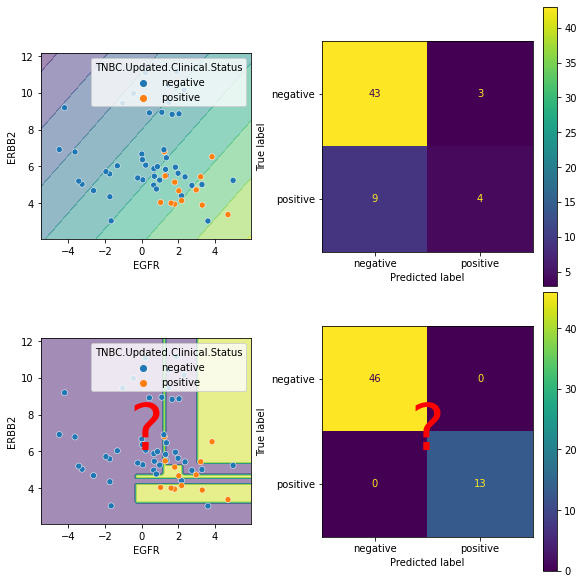

In [ ]:
features_train, features_test, labels_train, labels_test = \
  sklearn.model_selection.train_test_split(features, labels, test_size=0.5, random_state=RANDOM_SEED)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), constrained_layout=True)
for ax_ in (ax1, ax2, ax3, ax4): ax_.set_aspect('equal')

# Top left
clf1 = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC())
clf1.fit(X=features_train, y=labels_train)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=clf1, X=features_train, alpha=0.5, ax=ax1);
sns.scatterplot(x=features_train['EGFR'], y=features_train['ERBB2'], hue=labels_train, ax=ax1);

# Top right
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(estimator=clf1, X=features_train, y=labels_train, ax=ax2);

# Bottom left
plot_question_mark(ax3)
clf2 = sklearn.tree.DecisionTreeClassifier()
#clf2 = sklearn.neighbors.KNeighborsClassifier()
clf2.fit(X=features_train, y=labels_train)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=clf2, X=features_train, alpha=0.5, ax=ax3);
sns.scatterplot(x=features_train['EGFR'], y=features_train['ERBB2'], hue=labels_train, ax=ax3);

# Bottom right
plot_question_mark(ax4)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(estimator=clf2, X=features_train, y=labels_train, ax=ax4);

## Testing
Visualise performance of trained models on test data, discuss model complexity

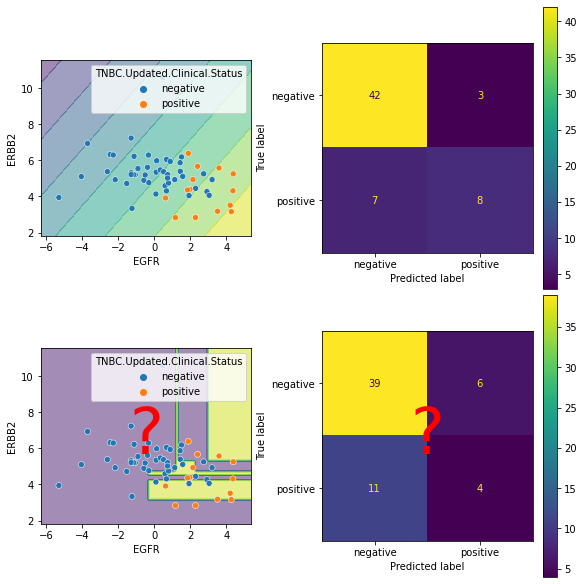

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), constrained_layout=True)
for ax_ in (ax1, ax2, ax3, ax4): ax_.set_aspect('equal')

# Top left
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=clf1, X=features_test, alpha=0.5, ax=ax1);
sns.scatterplot(x=features_test['EGFR'], y=features_test['ERBB2'], hue=labels_test, ax=ax1);

# Top right
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(estimator=clf1, X=features_test, y=labels_test, ax=ax2);

# Bottom left
plot_question_mark(ax3)
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(estimator=clf2, X=features_test, alpha=0.5, ax=ax3);
sns.scatterplot(x=features_test['EGFR'], y=features_test['ERBB2'], hue=labels_test, ax=ax3);

# Bottom right
plot_question_mark(ax4)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(estimator=clf2, X=features_test, y=labels_test, ax=ax4);

## Cross-validation

* Introduce cross-validation as an alternative to the 50/50 train/test split..
* Visualise as ROCs, maybe also as descision boundaries across different folds to illustrate model stability with a linear classifier vs decision tree?

In [ ]:
#sklearn.model_selection.cross_val_predict(estimator, X, y=None, *, groups=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', method='predict')

# 5 Model interpretability
- Predict TNBC using all genes; can we recapitulate our known genes-of-interest?
- Predict PAM50 using two different models; how well do they generalise; how do we assess multi-class prediction performance? How interpretable are they, e.g. can we recapitulate (some) of the original set of markers?

# Quiz questions?

1. Match decision boundary plots to AUC scores?
2. Some kind of a "story sauce" to test if they can recognise overfitting?
3. 
4. 
5. 